In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Reshape, Input, Dot, Dropout

In [2]:
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [3]:
BATCH_SIZE = 32
EPOCHS = 30
LATENT_DIM = 256
MAX_NUM_WORDS = 20000
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300

In [4]:
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

In [5]:
dataset = pd.read_csv("Symptom2Disease.csv")
dataset.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [6]:
texts= dataset['text'].values
labels = dataset['label'].values

In [7]:
tokenizer = Tokenizer(MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [8]:
word2idx = tokenizer.word_index
len(word2idx)

1575

In [9]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X.shape

(1200, 100)

In [10]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [11]:
classes = np.unique(labels)
targets = np.zeros((len(labels), len(classes)))

for i, d in enumerate(labels):
    targets[i, np.where(d==classes)] = 1

In [12]:
data = np.array([(x, y) for x, y in [*zip(X, targets)]])
data[0]

/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_2923/3629394019.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([(x, y) for x, y in [*zip(X, targets)]])


array([array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                0,   0,   0,   0,   0,   0,   0,   3,   6,   5,  29,   4,  15,
               48,  21,   2,  92,  79,   1, 808,  36,  10, 284, 137, 712,  20,
               11,  50,  96,   1, 326,  12, 110, 928, 209], dtype=int32)      ,
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
              0., 0., 0., 0., 0., 0., 0.])                                       ],
      dtype=object)

In [13]:
np.random.shuffle(data)

In [14]:
train_ds = data[:1000]
val_ds = data[1000:1100]
test_ds = data[1100:]

In [15]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for x, y in train_ds:
    x_train.append(x)
    y_train.append(y)

for x, y in val_ds:
    x_val.append(x)
    y_val.append(y)

for x, y in test_ds:
    x_test.append(x)
    y_test.append(y)

In [16]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [17]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [18]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH))

x = embedding_layer(input_)

rnn = Bidirectional(LSTM(LATENT_DIM, return_sequences=True))

h = rnn(x)

dense1 = Dense(10, activation='tanh')
dense2 = Dense(1, activation=softmax_over_time)

x = dense1(h)
alphas = dense2(x)

model1 = tf.keras.models.Model(inputs=[input_], outputs=[alphas])

dot = Dot(axes=1)

x = dot([alphas, h])

dense3 = Dense(100, activation='relu')
output_dense = Dense(len(classes), activation='softmax')

x = dense3(x)
x = Dropout(0.7)(x)
output = output_dense(x)

output = Reshape((24, ))(output)

model = tf.keras.models.Model(inputs=[input_], outputs=[output])

2023-05-19 10:33:00.199548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-19 10:33:00.199838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [19]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          472800    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 512)         1140736   
 l)                                                              
                                                                 
 dense (Dense)               (None, 100, 10)           5130      
                                                                 
 dense_1 (Dense)             (None, 100, 1)            11        
                                                                 
Total params: 1,618,677
Trainable params: 1,145,877
Non-trainable params: 472,800
_____________________________________________

In [128]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [129]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 300)     472800      ['input_6[0][0]']                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 100, 512)    1140736     ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 dense_16 (Dense)               (None, 100, 10)      5130        ['bidirectional_5[0][0]']  

In [130]:
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/30


2023-05-18 22:27:29.138105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-18 22:27:29.463392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-18 22:27:29.482569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-18 22:27:30.139963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-18 22:27:30.170615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 3.1364 - accuracy: 0.0770

2023-05-18 22:27:34.796046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-18 22:27:34.904774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-18 22:27:34.917520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 8s 164ms/step - loss: 3.1364 - accuracy: 0.0770 - val_loss: 2.9349 - val_accuracy: 0.1200
Epoch 2/30
32/32 [==============================] - 3s 84ms/step - loss: 2.6841 - accuracy: 0.2160 - val_loss: 2.0811 - val_accuracy: 0.4200
Epoch 3/30
32/32 [==============================] - 3s 83ms/step - loss: 1.8574 - accuracy: 0.4780 - val_loss: 1.2390 - val_accuracy: 0.7200
Epoch 4/30
32/32 [==============================] - 3s 81ms/step - loss: 1.2055 - accuracy: 0.6420 - val_loss: 0.8803 - val_accuracy: 0.7700
Epoch 5/30
32/32 [==============================] - 3s 83ms/step - loss: 0.8505 - accuracy: 0.7410 - val_loss: 0.6493 - val_accuracy: 0.8500
Epoch 6/30
32/32 [==============================] - 3s 84ms/step - loss: 0.5696 - accuracy: 0.8530 - val_loss: 0.4734 - val_accuracy: 0.8500
Epoch 7/30
32/32 [==============================] - 3s 88ms/step - loss: 0.4410 - accuracy: 0.8670 - val_loss: 0.4124 - val_accuracy: 0.8700
Epoch 8/30
32/32 [=====

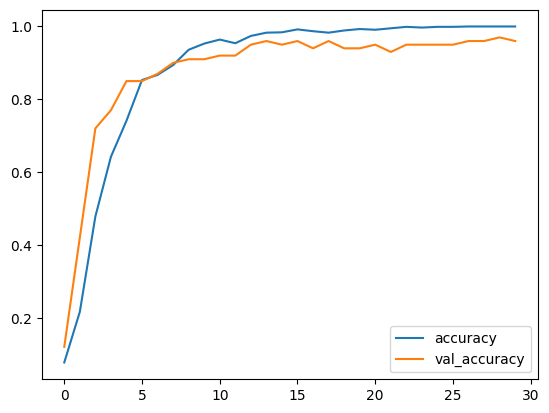

In [131]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

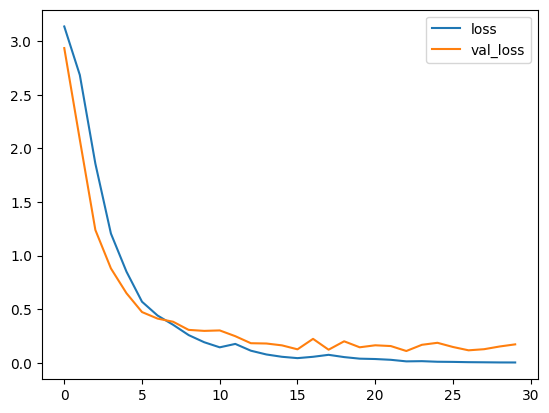

In [132]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [133]:
loss, accuracy = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 54ms/step - loss: 0.0690 - accuracy: 0.9800


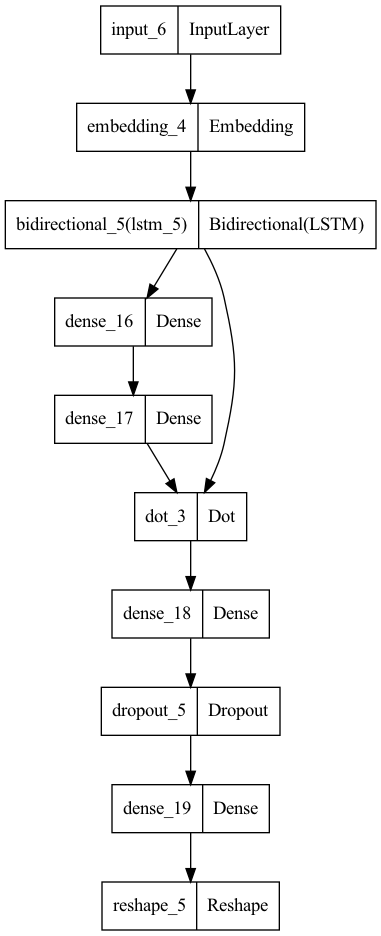

In [134]:
tf.keras.utils.plot_model(model)

In [135]:
model.save('model.h5')

In [21]:
model = tf.keras.models.load_model('model.h5', custom_objects={'softmax_over_time': softmax_over_time})

In [22]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 100, 300)     472800      ['input_6[0][0]']                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 100, 512)    1140736     ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 dense_16 (Dense)               (None, 100, 10)      5130        ['bidirectional_5[0][0]']  

In [236]:
random_idx = np.random.randint(len(x_test))

x_test_sample = x_test[random_idx]
y_test_sample = y_test[random_idx]

pred = model.predict(np.expand_dims(x_test_sample, axis=0))

1/1 [==============================] - 0s 55ms/step


In [237]:
assert classes[np.argmax(pred)] == classes[np.argmax(y_test_sample)]

In [238]:
idx2word = {v: k for k, v in word2idx.items()}

In [239]:
def sequence_to_sentence(sequence):
    return " ".join([idx2word[x] for x in sequence if x != 0])

In [240]:
sentence = sequence_to_sentence(x_test_sample)

In [241]:
rnn_with_attention_output = tf.keras.Sequential(layers=model.layers[:5])

In [242]:
alphas = rnn_with_attention_output.predict(np.expand_dims(x_test_sample, axis=0), verbose=0)[0]
alphas = np.reshape(alphas, (1, 100))

2023-05-19 11:32:12.918611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-19 11:32:13.000668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-19 11:32:13.014910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [243]:
start_from = np.where(x_test_sample != 0)[0][0]

In [244]:
alphas = alphas[:, start_from:]

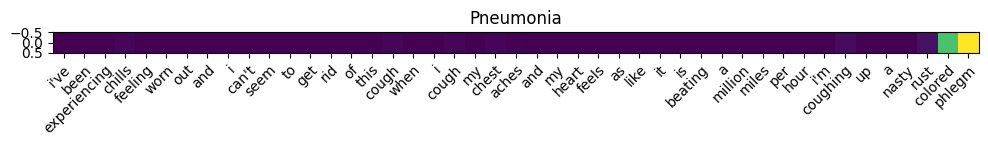

In [245]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas)

ax.set_xticks(np.arange(len(sentence.split())), labels=sentence.split())

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.title(classes[np.argmax(pred)])

fig.tight_layout()
plt.show()